# Notebook version of the attack pipeline on Adult

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append("../../")
sys.path.append("../../lime/")
import mlem
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer

# DATA LOADING AND CONFIGURATION

In [2]:
from mlem.utilities import load_pickle_bz2

data for the attack

In [3]:
BLACK_BOX = load_pickle_bz2("../datasets/adult/BB_NO_CLUSTERING/BB_DATA/adult_rf_noclustering.bz2")
# x_train x_test y_train y_test x_test_clustered y_test_clustered
BLACK_BOX_DATA = np.load("../datasets/adult/BB_NO_CLUSTERING/BB_DATA/adult_rf_noclustering_data_nsamples_2.npz")
CATEGORICAL_FEATURES_MASK = [False, True, False, True, False, True, True, True, True, True, False, False, False, True]

In [4]:
train_distr = pd.DataFrame(BLACK_BOX_DATA['y_train']).value_counts(normalize=True)
test_distr = pd.DataFrame(BLACK_BOX_DATA['y_test']).value_counts(normalize=True)

In [5]:
print(f"train size = {len(BLACK_BOX_DATA['y_train'])} | test size = {len(BLACK_BOX_DATA['y_test'])} | total size = {len(BLACK_BOX_DATA['y_train']) + len(BLACK_BOX_DATA['y_test'])}")
print(f"train distribution:\n{train_distr}\n")
print(f"test distribution:\n{test_distr}")

train size = 16877 | test size = 7234 | total size = 24111
train distribution:
0    0.750963
1    0.249037
dtype: float64

test distribution:
0    0.750899
1    0.249101
dtype: float64


X and Y are the row to attack

In [6]:
INDEX = 15

In [7]:
X = BLACK_BOX_DATA['x_test_clustered'][INDEX]
Y = BLACK_BOX_DATA['y_test_clustered'][INDEX]

### building the explainer

Training the explainer on the training data of the black box

In [8]:
explainer_training_data = BLACK_BOX_DATA['x_train']
explainer = LimeTabularExplainer(training_data=explainer_training_data, categorical_features=[i for (i, el) in enumerate(CATEGORICAL_FEATURES_MASK) if el], random_state=123)

# Attack Pipeline

## 1) Creating the local explainer

at the end of this section the important variables will be:
* `local_model` : contains the local model (the ensemble classifier generated by LIME)
* `x_neigh` : contains the neighborhood generated by LIME
* `y_neigh`: contains the classification of `x_neigh` generated by the local_model

This code is contained in the `__get_local_data` function in the mlem code

In [9]:
explanations, lime_models, x_neigh = explainer.explain_instance(X, BLACK_BOX.predict_proba, labels=[0,1], sampling_method="gaussian", num_samples=5000, num_features=len(X))

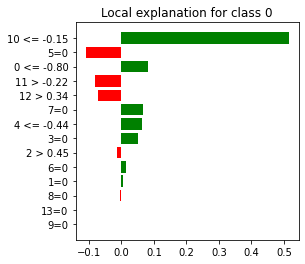

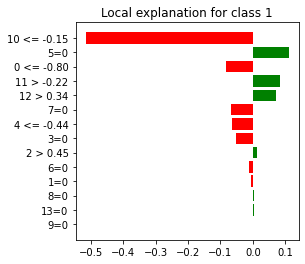

In [10]:
fig0 = explanations.as_pyplot_figure(label=0)
fig1 = explanations.as_pyplot_figure(label=1)

Difference between the points in the neighborhood and the original instance.

*The instances generated by LIME are not very close to the original instance, maybe we could generate neighborhoods in a loop and keep only the closest elements*

In [11]:
from mlem.utilities import norm_nocategorical
difference_from_X_cat = [np.linalg.norm(x_neigh[0]-x) for x in x_neigh]
difference_from_X_nocat = [norm_nocategorical(x_neigh[0]-x, CATEGORICAL_FEATURES_MASK) for x in x_neigh]
print(f"with cat:\tmax = {max(difference_from_X_cat[1:]):.2f} min = {min(difference_from_X_cat[1:]):.2f} avg = {np.average(difference_from_X_cat[1:]):.2f} std= {np.std(difference_from_X_cat[1:]):.2f}")
print(f"without cat:\tmax = {max(difference_from_X_nocat[1:]):.2f} min = {min(difference_from_X_nocat[1:]):.2f} avg = {np.average(difference_from_X_nocat[1:]):.2f} std= {np.std(difference_from_X_nocat[1:]):.2f}")

with cat:	max = 12.32 min = 1.56 avg = 6.07 std= 0.83
without cat:	max = 12.31 min = 1.49 avg = 6.04 std= 0.83


Creating the local model as ensamble of the models returned by lime

In [12]:
lime_models

[Ridge(alpha=1, random_state=RandomState(MT19937) at 0x7F26AE6AA940),
 Ridge(alpha=1, random_state=RandomState(MT19937) at 0x7F26AE6AA940)]

In [13]:
from mlem.ensemble import EnsembleClassifier
local_model = EnsembleClassifier(classifiers=lime_models)
y_neigh = local_model.predict(x_neigh)

Difference between the lime models, the local model (ensemble) and the black box in classifying the neighborhood generated by lime.

The first value corresponds to the instance around which we are building the neighborhood

In [14]:
lime_0_x_neigh_class = pd.DataFrame(lime_models[0].predict(x_neigh))
lime_1_x_neigh_class = pd.DataFrame(lime_models[1].predict(x_neigh))
ens_x_neigh_class = pd.DataFrame(y_neigh)
bb_x_neigh_class = pd.DataFrame(BLACK_BOX.predict(x_neigh))

The two models returned by LIME used to build the ensemble generate predictions that sum to 1

In [25]:
print((lime_0_x_neigh_class + lime_1_x_neigh_class >= .99).all().to_list())

[True]


Labels assignment of the ensemble and the black box on the neighborhood generated by LIME

In [16]:
ens_x_neigh_class.value_counts(normalize=True)

1    0.8418
0    0.1582
dtype: float64

In [17]:
bb_x_neigh_class.value_counts(normalize=True)

0    0.897
1    0.103
dtype: float64

**We can see that the ensemble inverts the label distribution**

Percentage of classifications where the ensemble and the bb agree:

In [18]:
(bb_x_neigh_class == ens_x_neigh_class).value_counts(normalize=True)

False    0.8864
True     0.1136
dtype: float64

**Let's see if the black box and the local explainer agree on the points of the neighborhood which are close to the instance used to generate the neigh.**

In [20]:
x_neigh_closest = np.array([x for x in x_neigh if np.linalg.norm(X-x) < 1.0 ])
print(f"{len(x_neigh_closest)=}")

len(x_neigh_closest)=1


The black box and the local model don't agree much or at all on the closest points. The more I set the threshold high, the more they disagree.

In [21]:
pd.DataFrame(BLACK_BOX.predict(x_neigh_closest) == local_model.predict(x_neigh_closest)).value_counts(normalize=True)

False    1.0
dtype: float64

In [22]:
print(f"The true label of the original instance X is {Y}")

The true label of the original instance X is 0


In [23]:
local_model.predict(x_neigh_closest)

array([1])

In [24]:
BLACK_BOX.predict(x_neigh_closest)

array([0])